## Class Project
Course: Integer and Network Optimization (ISEN-841)

(Written from scratch)

By: Negasa Yahi, 

    Michael Dejene Azage (Equal Contributions)
    
Course Professor: Dr. Faisal Alkhannan Alkaabneh

Date: Dec 01, 2022

# 1  Importing packages

In [1]:
#Importing packages
from gurobipy import Model, GRB, quicksum
import numpy as np
import random
import itertools #For computing cross products...
import time #For computational time analysis...

# 2  Sets Definition
Modularized Carts are  number of carts available. The following Fig 1.0 shows sample connected four modularized carts (MC). The connection of the MC shown typically represents type-4 connection. In general, the connection can be represented as typle-l where 'l' is the number of MC connected. For example in type-4 connection, 'l' is four.

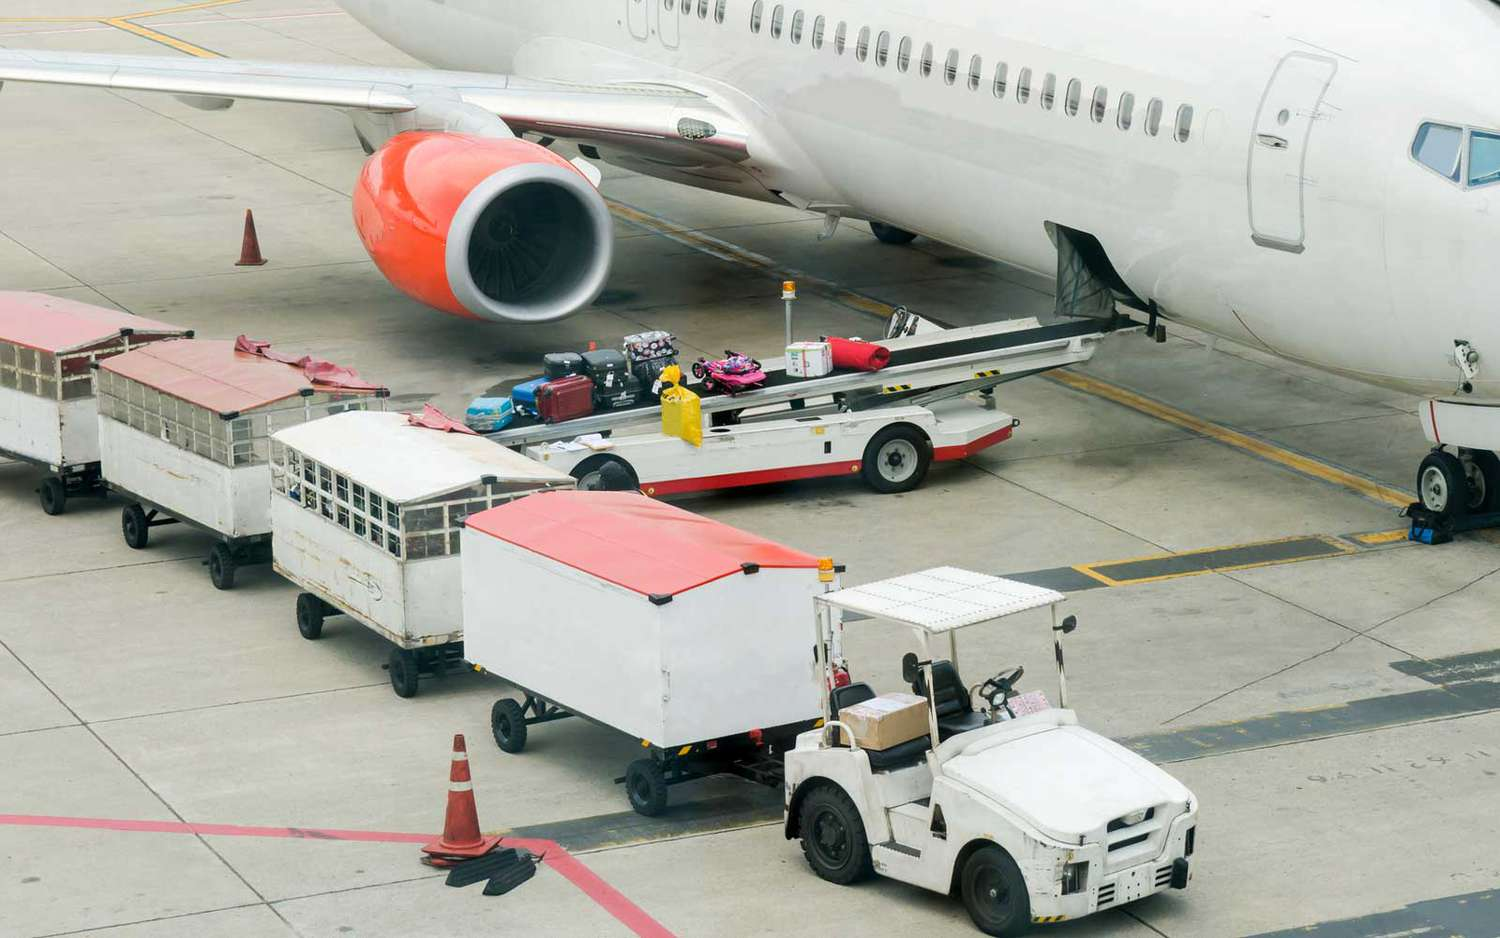

Fig 1.0: Sample connected baggage carts (or modularized carts, MC).

Assume that we have 'N' number of gates, and the maximum number of MC is L_max. 

Sets:

    I = {0,1,2,...,N-1}
    
    L = {1,2,...,L_max}
    
    T = {t_0, t_1, t_2,...,t_N}


In [2]:
L_max = 10 #Maximum Modularized Carts (MC) to be connected
N = 10
L = [l for l in range(1,L_max + 1)] #Set index to type of MC
I = [i for i in range(0,N)] #Set index to Gates

T = [t*60 for t in range(0,N)] #Time interval during which each airplane is loading begins...

# 3 Decision Variables

In [3]:
#Modeling
m=Model('AirportBag')

M = []
for i in range(0, N):    
    temp  = list(itertools.product(L,T[:i+1]))    
    for val in temp:
        x = val[0]
        y = val[1]
        M.append((i,x,y))
y_ilt = m.addVars(M, vtype=GRB.BINARY)  #1 if gate i is to be loaded with type-l at time t


Q = list(itertools.chain(*[list(itertools.product([I[j]],T[:j+1])) for j in range(0,len(I))]))
v_t =  m.addVars(T, lb=+0.0,vtype=GRB.INTEGER)
b_it =  m.addVars(Q, lb=+0.0, vtype=GRB.INTEGER)
p_it =  m.addVars(Q, lb=+0.0,vtype=GRB.INTEGER)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-29


# 4 Random Integer Numbers (Passengers Generation)

In [4]:
#generates n random integer numbers with given sum  k
def randomNumbersWithSum(n, k):
    """n numbers with sum k"""
    if n == 1:
        return [k]
    num = random.randint(1, k)
    return [num] + randomNumbersWithSum(n - 1, k - num + 1)

#For baggage and passengers: 80% assumptions 
maxCapacityPassengers = 500

dic_values = list(b_it.keys())

count = 0
for i in range(1,len(I) + 1):    
    randNumPassenger = (randomNumbersWithSum(i,maxCapacityPassengers-i + 1))
    randNumPassenger.sort()
    
    #randNumBaggage = list(np.floor(0.8*np.array(randNumPassenger)))
    for j in range(0,i):
        p_it[dic_values[count]] = randNumPassenger[j]
        #b_it[dic_values[count]] = randNumBaggage[j]
        
        count = count + 1
        
print(p_it)

{(0, 0): 500, (1, 0): 222, (1, 60): 278, (2, 0): 61, (2, 60): 88, (2, 120): 351, (3, 0): 25, (3, 60): 26, (3, 120): 216, (3, 180): 233, (4, 0): 1, (4, 60): 1, (4, 120): 102, (4, 180): 163, (4, 240): 233, (5, 0): 3, (5, 60): 5, (5, 120): 6, (5, 180): 63, (5, 240): 65, (5, 300): 358, (6, 0): 13, (6, 60): 17, (6, 120): 22, (6, 180): 25, (6, 240): 37, (6, 300): 44, (6, 360): 342, (7, 0): 1, (7, 60): 2, (7, 120): 22, (7, 180): 24, (7, 240): 29, (7, 300): 68, (7, 360): 87, (7, 420): 267, (8, 0): 1, (8, 60): 2, (8, 120): 3, (8, 180): 9, (8, 240): 12, (8, 300): 16, (8, 360): 47, (8, 420): 59, (8, 480): 351, (9, 0): 1, (9, 60): 1, (9, 120): 1, (9, 180): 1, (9, 240): 1, (9, 300): 1, (9, 360): 3, (9, 420): 4, (9, 480): 5, (9, 540): 482}


# 5 Objective Function

In [5]:
#Objective
K1 = 0.019
K2 = 0.006
C = 50 #Capacity of each MC

m.modelSense = GRB.MINIMIZE
m.setObjective(sum((K1 + K2*(C*l))*y_ilt[(i,l,t)] for i,l,t in M))


# 6 Constraints


In [6]:
V =  200 #Initial number of MCs available at the terminal
# Vehicle dispatch constarints
P = [list(itertools.product(I[j:],L)) for j in range(0,len(I))]
m.addConstrs((sum(l*y_ilt[(i,l,T[j])] for (i,l) in P[j]) <= v_t[T[j]] for j in range(0,len(T))),"Const-1")

m.addConstrs((sum(y_ilt[(i,l,t)] for l in L) == 1 for (i,t) in Q),"Const-2")
m.addConstr((v_t[T[0]] == V), "Const-3") 

m.addConstr((v_t[T[1]] == v_t[T[0]]  - (sum(l*y_ilt[(i,l,T[0])] for (i,l) in P[0]))), "Const-4_LoweBound")  
m.addConstrs((v_t[T[t+1]] == v_t[T[t]]  - sum(l*y_ilt[(i,l,T[t])] for (i,l) in P[t])
             +sum(l*y_ilt[(i,l,T[t-1])] for (i,l) in P[t]) for t in range(1,len(T)-1)), "Const-4")     
              

# baggage movement constraints
m.addConstrs((b_it[(i,T[0])] <= p_it[(i,T[0])] for i in I), "Const-7")

m.addConstrs((b_it[(i,t)] <= p_it[(i,t)] 
             + sum(p_it[(i,T[t_bar])]-b_it[(i,T[t_bar])] 
                   for t_bar in range(0, T.index(t))) for (i,t) in Q),"Const-8")


m.addConstrs((b_it[(i,t)] <= sum(C*l*y_ilt[(i,l,t)] for l in L) for (i,t) in Q),"Const-9")



m.addConstrs(( sum(b_it[(i,t_bar)] for t_bar in T[:i+1]) == sum(p_it[(i,t_bar)] 
                                                                for t_bar in T[:i+1]) for i in I),"Const-10")


{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>}

# 7 MIP Optimization

In [7]:
#If you want to see optimization time remove the the below comment
# and comment out m.optimize() and m.update
'''
monteCarloNumber = 2000
runTime = []

for i in range(0,monteCarloNumber):
    start_time = time.time()
    m.optimize()
    end_time = time.time()
    
    runTime.append((end_time - start_time)*1000)
    #m.display()
    m.update()

compTime = np.mean(np.array(runTime))
'''

m.optimize()
m.update()
#m.computeIIS()
#m.write("model.ilp")


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 205 rows, 670 columns and 2999 nonzeros
Model fingerprint: 0x97578326
Variable types: 0 continuous, 670 integer (550 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [3e-01, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 109 rows and 311 columns
Presolve time: 0.04s
Presolved: 96 rows, 359 columns, 1390 nonzeros
Variable types: 0 continuous, 359 integer (325 binary)
Found heuristic solution: objective 41.5450000
Found heuristic solution: objective 40.3450000

Root relaxation: objective 3.925900e+01, 34 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   39.25900    0    9   40.34500   39.25900  2.69% 

In [11]:
#Read the info provided about the computational time  in the above code cell...
#print("Computational time: " + str(compTime))

# 9 Results (Outputs)

In [8]:
y_ilt

{(0, 1, 0): <gurobi.Var C0 (value 0.0)>,
 (0, 2, 0): <gurobi.Var C1 (value 0.0)>,
 (0, 3, 0): <gurobi.Var C2 (value 0.0)>,
 (0, 4, 0): <gurobi.Var C3 (value 0.0)>,
 (0, 5, 0): <gurobi.Var C4 (value 0.0)>,
 (0, 6, 0): <gurobi.Var C5 (value 0.0)>,
 (0, 7, 0): <gurobi.Var C6 (value 0.0)>,
 (0, 8, 0): <gurobi.Var C7 (value 0.0)>,
 (0, 9, 0): <gurobi.Var C8 (value 0.0)>,
 (0, 10, 0): <gurobi.Var C9 (value 1.0)>,
 (1, 1, 0): <gurobi.Var C10 (value 0.0)>,
 (1, 1, 60): <gurobi.Var C11 (value 0.0)>,
 (1, 2, 0): <gurobi.Var C12 (value 1.0)>,
 (1, 2, 60): <gurobi.Var C13 (value 0.0)>,
 (1, 3, 0): <gurobi.Var C14 (value -0.0)>,
 (1, 3, 60): <gurobi.Var C15 (value 0.0)>,
 (1, 4, 0): <gurobi.Var C16 (value -0.0)>,
 (1, 4, 60): <gurobi.Var C17 (value 0.0)>,
 (1, 5, 0): <gurobi.Var C18 (value 0.0)>,
 (1, 5, 60): <gurobi.Var C19 (value 0.0)>,
 (1, 6, 0): <gurobi.Var C20 (value 0.0)>,
 (1, 6, 60): <gurobi.Var C21 (value 0.0)>,
 (1, 7, 0): <gurobi.Var C22 (value 0.0)>,
 (1, 7, 60): <gurobi.Var C23 (value

In [9]:
b_it

{(0, 0): <gurobi.Var C560 (value 500.0)>,
 (1, 0): <gurobi.Var C561 (value 100.0)>,
 (1, 60): <gurobi.Var C562 (value 400.0)>,
 (2, 0): <gurobi.Var C563 (value 50.0)>,
 (2, 60): <gurobi.Var C564 (value 50.0)>,
 (2, 120): <gurobi.Var C565 (value 400.0)>,
 (3, 0): <gurobi.Var C566 (value 1.0)>,
 (3, 60): <gurobi.Var C567 (value 50.0)>,
 (3, 120): <gurobi.Var C568 (value 99.0)>,
 (3, 180): <gurobi.Var C569 (value 350.0)>,
 (4, 0): <gurobi.Var C570 (value -0.0)>,
 (4, 60): <gurobi.Var C571 (value 2.0)>,
 (4, 120): <gurobi.Var C572 (value 100.0)>,
 (4, 180): <gurobi.Var C573 (value 98.0)>,
 (4, 240): <gurobi.Var C574 (value 300.0)>,
 (5, 0): <gurobi.Var C575 (value -0.0)>,
 (5, 60): <gurobi.Var C576 (value -0.0)>,
 (5, 120): <gurobi.Var C577 (value 0.0)>,
 (5, 180): <gurobi.Var C578 (value 50.0)>,
 (5, 240): <gurobi.Var C579 (value 50.0)>,
 (5, 300): <gurobi.Var C580 (value 400.0)>,
 (6, 0): <gurobi.Var C581 (value -0.0)>,
 (6, 60): <gurobi.Var C582 (value 0.0)>,
 (6, 120): <gurobi.Var C583

In [10]:
v_t

{0: <gurobi.Var C550 (value 200.0)>,
 60: <gurobi.Var C551 (value 180.0)>,
 120: <gurobi.Var C552 (value 174.0)>,
 180: <gurobi.Var C553 (value 165.0)>,
 240: <gurobi.Var C554 (value 160.0)>,
 300: <gurobi.Var C555 (value 156.0)>,
 360: <gurobi.Var C556 (value 149.0)>,
 420: <gurobi.Var C557 (value 143.0)>,
 480: <gurobi.Var C558 (value 137.0)>,
 540: <gurobi.Var C559 (value 130.0)>}